# Introduction
The goal of this project is to use twitter streaming API to collect text data, and perform Natural Language Processing (NLP) for sentiment analysis, and do a statistical analysis to see if a tweet in reply to different gender / affiliation, to see if the result shows statistically meaningful difference in terms of aggression / insult. The degree of "aggression/ insult" in a text are modeled based on https://arxiv.org/ftp/arxiv/papers/1604/1604.06648.pdf
https://arxiv.org/pdf/1604.06650.pdf
https://arxiv.org/pdf/1702.06877.pdf
and references therein.
As a pilot survey, we only include 50 significant figures on twitter according to wikipedia (whose gender is known). Accounts for groups / organizations are hand-picked and removed. We only collect tweets that have replies. 

# Data
Uses of twitter APIata collecting and preprocessing step reference:
https://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/

## Training data
For training purposes, we started by collecting aggressive users on twitter and their tweets, provided by Despoina Chatzakou (Mean Birds): https://arxiv.org/pdf/1702.06877.pdf
However many of the tweets are unaccessible due to user suspension / authorization issues.
http://www.yichang-cs.com/yahoo/WWW16_Abusivedetection.pdf and dataset provided therein (e.g. Kaggle challenge) provides insulting comments with verification set.
The list of Google-banned bad words are obtained via https://www.freewebheaders.com/full-list-of-bad-words-banned-by-google/
We also apply GloVe and see how the result appears.
## Test data
Using Twitter streaming API, we collect tweets in reply to top 50 most followed users on twitter according to Wikipedia. The size of the dataset is 10k tweets to start with. 

# Processing tweets
We perform standard pre-processing of the tweeter text data, which involves:
tokenize, removing stop words, twitter-specific features (e.g. RT, @, ...).

# Analysis
We test various sentiment analysis here. We use Vader as a starter, to assess the performance of a typical and easy-to-use sentiment analyzer on our training / verification data. We then test various widely used word embedding and algorithm to assess the performance of themover Vader. Finally we apply the algorithm to collected tweets, visualize and understand the result.

## Word embedding
### TfidfVectorizer
CountVectorizer (simple token count)-> TfidfTransformer. Probably more suitable for a large corpus with consistent context.
### GloVe
pre-trained unsupervised word clustering / vetorization of words provided by Stanford group.

## Classification
### Vader 
Pre-trained positive / negtaive sentiment analyzer. Tweets can be classifies with the intensity of the sentiment. 
### RNN
RNN is a standard choice for sequence modeling (especially text data). We implemented RNN using Keras.

In [1]:
# TIP: Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install numpy

In [2]:
try:
    import json
except ImportError:
    import simplejson as json

# Import the necessary methods from "twitter" library
# from twitter import Twitter, OAuth, TwitterHTTPError, TwitterStream

In [129]:
import pandas as pd
user_info = pd.read_csv('user_info.csv')
# hand-put gender to the user_info: F, M, G (group)

In [130]:
# hand-put gender to the user_info: Female, Male, Group (an organization or platform, or multiple people)
a = 'FMMFFFFMGMGFFFFFGMFMMFMMFGMFGMMGGMMGMMMGMMMFMMGFGM'
g = list(a)
g = pd.Series(g)
user_info = user_info.assign(gender= g.values)

In [229]:
print(user_info.head(5))

   Unnamed: 0               activity country  followers   user_id  \
0           0               Musician     USA        110  21447363   
1           1               Musician     CAN        107  27260086   
2           2  Former U.S. President     USA        103    813286   
3           3               Musician     BAR         89  79293791   
4           4               Musician     USA         86  17919972   

       user_name gender  
0      katyperry      F  
1   justinbieber      M  
2    BarackObama      M  
3        rihanna      F  
4  taylorswift13      F  


In [161]:
# estimate the activity level of each users and include it to the user_info dataframe
# collecting tweets are again, done using Collect_tweetw_50mostpop_users.ipynb
past_filename = 'past_100_tweets.json'
with open(past_filename) as f:
    pasts = json.load(f)

In [196]:
from datetime import datetime
import re
unformatted = "Thu Oct 20 02:40:55 +0000 2016"

def convert_time(twitter_time):
# Use re to get rid of the milliseconds.
    remove_ms = lambda x:re.sub("\+\d+\s","",x)
# Make the string into a datetime object.
    mk_dt = lambda x:datetime.strptime(remove_ms(x), "%a %b %d %H:%M:%S %Y")
# Format your datetime object.
#    my_form = lambda x:"{:%Y%m%d}".format(mk_dt(x))
    return mk_dt(twitter_time)

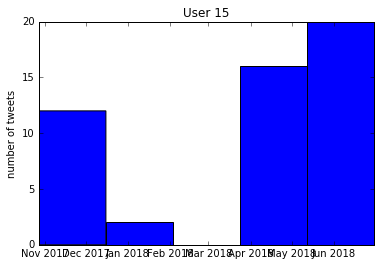

In [232]:
u = 15
test = [convert_time(pasts[u][i]['created_at']) for i in range(50)]
test = test[::-1]
plt.hist(test,bins=5)
plt.ylabel("number of tweets")
plt.title("User %d"%(u))

## poisson distribution and 95% confidence interval
http://ms.mcmaster.ca/peter/s743/poissonalpha.html

# Modeling activity of the user
We model the activity of each user at the current time interval (where the streaming data was collected) using Poisson distribution to test whether the user is particularly more / less active in the given time bin. We estimate l as the average number of tweets per bin, and k to be the number of tweets in the bin where streaming data is collected. The probability of obtaining k tweets when average is l is then:

p(k) = exp(-l)l^k/(k!).

In [137]:
tweets_filename = 'twitter_savereplies_nsamp10000.json'
tweets_filename2 = 'twitter_savereplies_nsamp20000.json'
tweets_filename3 = 'twitter_savereplies_nsamp30000.json'
tweets_filename4 = 'twitter_savereplies_nsamp40000.json'

import os.path
# save to json file
tweet_count = 100
tweet_cnt = tweet_count
try:
    os.path.isfile(tweets_filename)
    os.path.isfile(tweets_filename2)
    print("files exists")
    with open(tweets_filename, 'r') as f:
        tweets = json.load(f) # readline only the first tweet/line
    with open(tweets_filename2, 'r') as f:
        tweets2 = json.load(f) # readline only the first tweet/line
    with open(tweets_filename3, 'r') as f:
        tweets3 = json.load(f) # readline only the first tweet/line
    with open(tweets_filename4, 'r') as f:
        tweets4 = json.load(f) # readline only the first tweet/line
    pass
except:
    print("file does not exist, stream twitter for collecting tweets")
    tweets = []
    for tweet in iterator:
    # select only "replies" to top 50 followed users
        if str(tweet['in_reply_to_user_id']) in user_id:
        #print(tweet['in_reply_to_user_id'])
            tweet_count -= 1
            tweets.append(tweet)
    # Twitter Python Tool wraps the data returned by Twitter 
    # as a TwitterDictResponse object.
    # We convert it back to the JSON format to print/score
    # loads converts json format to python dictionary
    # dumps converts python dictionary to json format
    # The command below will do pretty printing for JSON data, try it out
    # print json.dumps(tweet, indent=4)
            if tweet_count <= 0:
                break     
    with open(tweets_filename, 'w') as outfile:
        json.dump(tweets,outfile,indent=4)
text = []
for i0 in range(tweet_cnt):
    text.append(tweets[i0]['text'])

files exists


In [5]:
# feature extractor function
def bag_of_words(tweet):
    words = clean_tweets(tweet)
    words_dictionary = dict([word, True] for word in words)    
    return words_dictionary

# External dataset
We use external data (corpus with sentiment labels) to train the network, from i) Kaggle challenge, ii) banned words by Google (not a official list, obtained from https://www.freewebheaders.com/full-list-of-bad-words-banned-by-google/), and iii) Mean Birds: https://arxiv.org/pdf/1702.06877.pdf and private communication with the first author (Despoina Chatzakou).

In [6]:
banwords_file = './Google_BanWords/full-list-of-bad-words-text-file_2018_03_26.txt'
insult_corpus_file = './kaggle_insult/train.csv'
insult_train = pd.read_csv(insult_corpus_file)
banwords = pd.read_csv(banwords_file,sep='\r\n',engine='python',names = ['banword'])

In [7]:
insult = insult_train.loc[insult_train['Insult']==1]
normal = insult_train.loc[insult_train['Insult']==0]
print((insult['Comment'][0]))
print(len(normal))

"You fuck your dad."
2898


In [8]:
import numpy as np
training_file = './dataset/data'
training_data = pd.read_csv(training_file,delim_whitespace=True,names=['user','category','tweet_id'])
ID = []
for i in range(len(training_data)):
    ID.append(training_data['tweet_id'][i].split(","))
#print(training_data)
# category is divided into four: aggressor, bully, normal and spammer
# each up to (43, 101, 883, 1303) id indices and 5-10 tweets.
# It can take long time to collect these tweets, so I save them as json files with their indices provided in the dataset.

In [9]:
# saved aggressive / bullying tweets for later runs
agg_filename = 'agg_tweets.json'
bull_filename= 'bull_tweets.json'
norm_filename = 'norm_tweets.json' 

In [10]:
#t.statuses.oembed(_id=672282716436467714)
try:
    os.path.isfile(agg_filename)
    with open(agg_filename, 'r') as f:
        agg_tweets = json.load(f) # readline only the first tweet/line
    print("agg_file exist: read and pass")
    pass
except:
    print("agg_file does not exist: collect tweets from twitter database")
    agg_tweets = []
    agg_index = []
    ID_idx = [len(x) for x in ID]
    for i in range(0,43):
        for j in range(ID_idx[i]):
            try:
                agg_tweets.append(t.statuses.show(_id=ID[i][j]))
                agg_index.append(i)
                print(i,j)
            except:
                pass
    with open(agg_filename, 'w') as outfile:
        json.dump(agg_tweets,outfile,indent=4)
    with open('agg_tweets_idx.txt','w') as outfile:
        json.dump(agg_index,outfile)
    print("aggressive tweets collected and saved")

agg_file exist: read and pass


In [11]:
#t.statuses.oembed(_id=672282716436467714)
try:
    os.path.isfile(bull_filename)
    with open(bull_filename, 'r') as f:
        bull_tweets = json.load(f) # readline only the first tweet/line
    print("bull_file exist: read and pass")
    pass
except:
    print("bull_file does not exist: collect tweets from twitter database")
    ID_idx = [len(x) for x in ID]
    bull_tweets = []
    bull_index = []
    for i in range(43,101):
        for j in range(ID_idx[i]):
            try:
                bull_tweets.append(t.statuses.show(_id=ID[i][j]))
                bull_index.append(i)
                print(i,j)
            except:
                pass
    with open(bull_filename, 'w') as outfile:
        json.dump(bull_tweets,outfile,indent=4)
    with open('bull_tweets_idx.txt','w') as outfile:
        json.dump(bull_index,outfile)
    print("bully tweets collected and saved")

bull_file exist: read and pass


In [12]:
#t.statuses.oembed(_id=672282716436467714)
try:
    os.path.isfile(norm_filename)
    with open(norm_filename, 'r') as f:
        norm_tweets = json.load(f) # readline only the first tweet/line
    print("norm_file exist: read and pass")
    pass
except:
    print("norm_file does not exist: collect tweets from twitter database")
    norm_tweets = []
    norm_index = []
    ID_idx = [len(x) for x in ID]
    for i in range(101,883):
        for j in range(ID_idx[i]):
            try:
                norm_tweets.append(t.statuses.show(_id=ID[i][j]))
                norm_index.append(i)
                print(i,j)
            except:
                pass
    with open(norm_filename, 'w') as outfile:
        json.dump(norm_tweets,outfile,indent=4)
    with open('norm_tweets_idx.txt','w') as outfile:
        json.dump(norm_index,outfile)
    print("normal tweets collected and saved")

norm_file exist: read and pass


In [13]:
norm_tweets_text = [norm_tweets[i]['text'] for i in range(len(norm_tweets))]
# tweets from aggressive + bullying users currently available are about 100... :x

In [14]:
# tweeter seems to have worked well and suspended most of the accounts the authors classified as aggressors / bullies,
# which is unfortunate for our purpose but we will proceed with the currently available data...?

# Processing the text
Using nltk, we pre-process the text here. Tokenized words will be feed into multiple classifier to determine the degree of aggression in the text. We compare their performances and decide which algorithm to use.

In [15]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=False)

In [16]:

 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

In [17]:
import string
 
from nltk.corpus import stopwords 
stopwords_english = stopwords.words('english')
 
from nltk.stem import PorterStemmer, WordNetLemmatizer
stemmer = PorterStemmer()
wnl = WordNetLemmatizer()

from nltk.tokenize import TweetTokenizer
 
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
 
# all emoticons (happy + sad)
emoticons = emoticons_happy.union(emoticons_sad)
 
def clean_tweets(tweet):
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)    
    # remove abbreviation marks?
    tweet = re.sub(r'/[.]{2,}/g','',tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
 
    tweets_clean = []    
    for word in tweet_tokens:
        if (word not in stopwords_english and # remove stopwords
              word not in emoticons and # remove emoticons
                word not in string.punctuation): # remove punctuation
            #tweets_clean.append(word)
            #stem_word = stemmer.stem(word) 
            # stemming word : tend to remove 'e' from ending of some words. replaced by WordNetLemmatizer
            wnl_word = wnl.lemmatize(word)
            #tweets_clean.append(stem_word)
            tweets_clean.append(wnl_word)
 
    return tweets_clean

In [18]:
def tokenize(tweet):
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r"#(\w+)", '', tweet)
    tweet = re.sub(r"@(\w+)", '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = tweet.strip().lower()
    tokens = word_tokenize(tweet)
    return tokens

In [19]:
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

In [20]:
print(preprocess(text[50]))
print(clean_tweets(text[50]))

['let', 'a', 'mexican', 'replace', 'you', 'not', 'italian', 'as', 'it', 'was', 'supposed', 'as', 'next', 'potus', 'they', 'are', 'too', 'violent', 'i']
['let', 'mexican', 'replace', 'italian', 'supposed', 'next', 'potus', 'violent', '…']


In [21]:
# let's import verification data from the Kaggle challenge
ver_file = './kaggle_insult/impermium_verification_labels.csv'
ver_data = pd.read_csv(ver_file)
print(ver_data.head(5))

insult = ver_data.loc[ver_data['Insult']==1]
normal = ver_data.loc[ver_data['Insult']==0]

insult_ver_set = []
for tweet in insult['Comment']:
    insult_ver_set.append((bag_of_words(tweet), 'ins'))
    
norm_ver_set = []
for tweet in normal['Comment']:
    norm_ver_set.append((bag_of_words(tweet), 'norm'))
    
train_x = insult_train['Comment'][:]
train_y = insult_train['Insult'][:]
ver_x = ver_data['Comment'][:]
ver_y = ver_data['Insult'][:]

   id  Insult             Date  \
0   1       0  20120603163526Z   
1   2       1  20120531215447Z   
2   3       1  20120823164228Z   
3   4       1  20120826010752Z   
4   5       1  20120602223825Z   

                                             Comment        Usage  
0                 "like this if you are a tribe fan"  PrivateTest  
1              "you're idiot......................."  PrivateTest  
2  "I am a woman Babs, and the only "war on women...  PrivateTest  
3  "WOW & YOU BENEFITTED SO MANY WINS THIS YEAR F...  PrivateTest  
4  "haha green me red you now loser whos winning ...  PrivateTest  


In [22]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.models import Sequential

from keras.layers import Input, Dense, Embedding, Conv1D, Conv2D, MaxPooling1D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.layers import SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D

from keras.callbacks import Callback
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [23]:
def get_coefs(word, *arr):
    try:
        return word, np.asarray(arr, dtype='float32')
    except:
        return None, None
    
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open('../GloVe/glove.twitter.27B.200d.txt'))

embed_size=200
for k in list(embeddings_index.keys()):
    v = embeddings_index[k]
    try:
        if v.shape != (embed_size, ):
            embeddings_index.pop(k)
    except:
        pass
            
#embeddings_index.pop(None)  

In [24]:
values = list(embeddings_index.values())
all_embs = np.stack(values)

emb_mean, emb_std = all_embs.mean(), all_embs.std()

In [25]:
# we try uni-/bigram (word / character) approach here following 
# https://ahmedbesbes.com/overview-and-benchmark-of-traditional-and-deep-learning-models-in-text-classification.html
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_auc_score
from sklearn.externals import joblib

import scipy
from scipy.sparse import hstack

In [26]:
# Try TFIDF 
vectorizer_word = TfidfVectorizer(max_features=40000,
                             min_df=5, 
                             max_df=0.5, 
                             analyzer='word', 
                             stop_words='english', 
                             ngram_range=(1, 2))

vectorizer_word.fit(train_x)

tfidf_matrix_word_train = vectorizer_word.transform(train_x)
tfidf_matrix_word_test = vectorizer_word.transform(ver_x)

In [27]:
lr_word = LogisticRegression(solver='sag', verbose=2)
lr_word.fit(tfidf_matrix_word_train, train_y)

convergence after 19 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=2, warm_start=False)

In [28]:
joblib.dump(lr_word, 'lr_word_ngram.pkl')

y_pred_word = lr_word.predict(tfidf_matrix_word_test)
pd.DataFrame(y_pred_word, columns=['y_pred']).to_csv('lr_word_ngram.csv', index=False)

In [29]:
y_pred_word = pd.read_csv('lr_word_ngram.csv')
print(accuracy_score(ver_y, y_pred_word))

0.656823266219


In [30]:
vectorizer_char = TfidfVectorizer(max_features=40000,
                             min_df=5, 
                             max_df=0.5, 
                             analyzer='char', 
                             ngram_range=(1, 4))

vectorizer_char.fit(train_x);

tfidf_matrix_char_train = vectorizer_char.transform(train_x)
tfidf_matrix_char_test = vectorizer_char.transform(ver_x)

lr_char = LogisticRegression(solver='sag', verbose=2)
lr_char.fit(tfidf_matrix_char_train, train_y)

y_pred_char = lr_char.predict(tfidf_matrix_char_test)
joblib.dump(lr_char, 'lr_char_ngram.pkl')

pd.DataFrame(y_pred_char, columns=['y_pred']).to_csv('lr_char_ngram.csv', index=False)

convergence after 17 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


In [31]:
y_pred_char = pd.read_csv('lr_char_ngram.csv')
print(accuracy_score(ver_y, y_pred_char))

0.663982102908


In [32]:
 
custom_tweet = "RT @Twitter @chapagain Hello There! Have a great day. :) #good #morning http://chapagain.com.np"
print (bag_of_words(custom_tweet))
'''
Output:
 
{'great': True, 'good': True, 'morning': True, 'hello': True, 'day': True}
'''
# insult tweets feature set
insult_tweets_set = []
for tweet in insult['Comment']:
    insult_tweets_set.append((bag_of_words(tweet), 'ins'))    
for words in banwords['banword']:
    insult_tweets_set.append((bag_of_words(words),'ins'))
# normal tweets feature set
normal_tweets_set = []
for tweet in normal['Comment']:
    normal_tweets_set.append((bag_of_words(tweet), 'norm'))
for tweet in norm_tweets_text:
    normal_tweets_set.append((bag_of_words(tweet), 'norm'))
print(len(insult_tweets_set), len(normal_tweets_set))

{'good': True, 'morning': True, 'day': True, 'hello': True, 'great': True}
2326 4053


In [33]:
print(normal_tweets_set[1])

({"nwhat's": True, 'nme': True, 'a-fag-and': True, 'refrigerator': True, 'fart': True, 'hate-faggots': True, 'god': True, 'nrefrigerators': True, 'put': True, 'meat': True, 'n': True, 'difference': True}, 'norm')


In [34]:
# try n-fold (minibatch) later
from random import shuffle, seed
seed(10)
shuffle(insult_tweets_set)
shuffle(normal_tweets_set)
 
#test_set = insult_tweets_set[:1000] + normal_tweets_set[:1000]
#train_set = insult_tweets_set[1000:] + normal_tweets_set[1000:]
train_set = insult_tweets_set + normal_tweets_set
test_set = insult_ver_set + norm_ver_set
print(len(test_set),  len(train_set)) # Output: (2000, 8000)

2235 6379


# Word embedding: efficient vectorization of words
By vectorizing words, we can reduce the sparcity and dimensionality of the feature space. 
The representation is normally ~ 100-1000 dimension. The basic concept behind it is that words used in
similar context have similar meanings.
## Embedding layer
Using NN for language modeling or document classification. 
## Word2vec
probably not easy with twitter texts as individual tweets are very short and thus predicting word from the surrounding (both for CBoW and Cont. skip-gram) would be hard? : not much freedom in choosing the sliding window size...
## GloVe
Word2Vec with additional information about the context from the whole corpus. Provides "Unsupervised" clustering of vocab, purely based on a large corpus of data. We use pre-trained GloVe vocabulary vector library collected from Twitter data from https://github.com/stanfordnlp/GloVe (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB).

Reference : https://machinelearningmastery.com/what-are-word-embeddings/

### Vader sentiment analysis (pos,neg)- how useful is it? Let's see!

In [35]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
#AttributeError: 'SentimentIntensityAnalyzer' object has no attribute 'polarity_score'

In [36]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
cnt = 0
insult_cmt = insult.reset_index()
for i in range(len(insult_cmt)):
    snt = analyser.polarity_scores(insult_cmt['Comment'][i])
    if snt.get('neg') > snt.get('pos'):
        cnt += 1
#        print(i,snt)
print(cnt/len(insult))
print(insult_cmt['Comment'][10])
# only about 11% of the ban words are categorized as having negative connotation according to Vader.
# only 9% of the insult comments from Kaggle competition are negative if neg > .5 is counted.
# (when negative > positive: 63% : this is similar to our NBC result).

/home/ijee/anaconda3/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


0.564531104921077
"You're a crank."


In [37]:
from nltk import classify
import nltk.classify.util, nltk.metrics
from nltk.classify import NaiveBayesClassifier, MaxentClassifier, SklearnClassifier, DecisionTreeClassifier
from sklearn import cross_validation
from sklearn.svm import LinearSVC, SVC
import itertools
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

print("!!!NaiveBayesClassifier!!!")
nbclassifier = NaiveBayesClassifier.train(train_set)
accuracy = classify.accuracy(nbclassifier, test_set)
print(accuracy) # Output: 0.765
print (nbclassifier.show_most_informative_features(10)) 

print("!!!MaxEntropyClassifier!!!")
classifier = MaxentClassifier.train(train_set, 'GIS', trace=0, encoding=None, labels=None, gaussian_prior_sigma=0, max_iter = 1)
accuracy = nltk.classify.util.accuracy(classifier, test_set)
print(accuracy)
print(classifier.show_most_informative_features(10))

# SVM takes long to run so we comment out this part. The accuracy was 0.622
#print("!!!SVM!!!")
#svmclassifier = SklearnClassifier(SVC(kernel='linear',probability=True), sparse=False)
#svmclassifier.train(train_set)
#accuracy = nltk.classify.util.accuracy(svmclassifier, test_set)
#print(accuracy)

print("!!!LinearSVM!!!")
lsvmclassifier = SklearnClassifier(LinearSVC(), sparse=False)
lsvmclassifier.train(train_set)
accuracy = nltk.classify.util.accuracy(lsvmclassifier, test_set)
print(accuracy)

!!!NaiveBayesClassifier!!!


/home/ijee/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.9006711409395973
Most Informative Features
               direction = True             norm : ins    =     43.4 : 1.0
                       � = True              ins : norm   =     33.6 : 1.0
                    vote = True             norm : ins    =     33.4 : 1.0
                     ang = True             norm : ins    =     30.8 : 1.0
                   moron = True              ins : norm   =     29.6 : 1.0
                      sa = True             norm : ins    =     27.0 : 1.0
                  result = True             norm : ins    =     22.8 : 1.0
                      ng = True             norm : ins    =     20.5 : 1.0
                   troll = True              ins : norm   =     18.5 : 1.0
                   photo = True             norm : ins    =     17.0 : 1.0
None
!!!MaxEntropyClassifier!!!
0.7861297539149888
  -0.000 direction==True and label is 'ins'
  -0.000 ang==True and label is 'ins'
  -0.000 vote==True and label is 'ins'
  -0.000 sa==True and label is 'i

In [38]:
custom_tweet = "I hated the film. It was a disaster. Poor direction, bad acting."
custom_tweet_set = bag_of_words(agg_tweets[30]['text'])
print(custom_tweet_set)
print (lsvmclassifier.classify(custom_tweet_set)) # Output: neg
# Negative tweet correctly classified as negative

# probability result
#prob_result = lsvmclassifier.prob_classify(custom_tweet_set)
#print (prob_result) # Output: <ProbDist with 2 samples>
#print (prob_result.max()) # Output: neg
#print (prob_result.prob("ins")) # Output: 0.941844352481
#print (prob_result.prob("norm")) # Output: 0.0581556475194
 
 
#custom_tweet = "It was a wonderful and amazing movie. I loved it. Best direction, good acting."
#custom_tweet_set = bag_of_words(custom_tweet)
 
print (lsvmclassifier.classify(custom_tweet_set)) # Output: pos
# Positive tweet correctly classified as positive
 
# probability result
#prob_result = svmclassifier.prob_classify(custom_tweet_set)
#print (prob_result) # Output: <ProbDist with 2 samples>
#print (prob_result.max()) # Output: pos
#print (prob_result.prob("ins")) # Output: 0.00131055449755
#print (prob_result.prob("norm")) # Output: 0.998689445502

{'academic': True, 'racism': True, 'racist': True, 'academ': True, '–': True, 'parliament': True, 'town': True, 'uct': True, '...': True, 'university': True, 'mp': True, 'lash': True, 'cape': True}
norm
norm


In [39]:
MAX_NB_WORDS = 80000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS,char_level=False)

insult['tokens'] = insult.Comment.map(tokenize)
insult['cleaned_text'] = insult['tokens'].map(lambda tokens: ' '.join(tokens))
print(insult['cleaned_text'][15])
tokenizer.fit_on_texts(insult['cleaned_text'])
print(tokenizer.texts_to_sequences([insult['cleaned_text'][15]]))

/home/ijee/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


youre a crank
[[19, 2, 1642]]


/home/ijee/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [40]:
train_sequences = tokenizer.texts_to_sequences(train_x)
test_sequences = tokenizer.texts_to_sequences(ver_x)

In [41]:
MAX_LENGTH = 35

padded_train_sequences = pad_sequences(train_sequences, maxlen=MAX_LENGTH)
padded_test_sequences = pad_sequences(test_sequences, maxlen=MAX_LENGTH)

In [42]:

word_index = tokenizer.word_index
nb_words = MAX_NB_WORDS
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

oov = 0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        oov += 1

print(oov)

embedding_dim = 200
def get_rnn_model_with_glove_embeddings():
    inp = Input(shape=(MAX_LENGTH, ))
    x = Embedding(MAX_NB_WORDS, embedding_dim, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)(inp)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(GRU(100, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

rnn_model_with_embeddings = get_rnn_model_with_glove_embeddings()

filepath="./models/rnn_with_embeddings/weights-improvement-{epoch:02d}-{val_acc:.4f}-%03d.hdf5"%(embedding_dim)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

batch_size = 128
epochs = 20


history = rnn_model_with_embeddings.fit(x=padded_train_sequences, 
                    y=train_y, 
                    validation_data=(padded_test_sequences, ver_y), 
                    batch_size=batch_size, 
                    callbacks=[checkpoint], 
                    epochs=epochs, 
                    verbose=1)


945
Train on 3947 samples, validate on 2235 samples
Epoch 1/20
3947/3947 [==============================] - 56s - loss: 0.5505 - acc: 0.7352 - val_loss: 0.7281 - val_acc: 0.5324
Epoch 2/20
3947/3947 [==============================] - 54s - loss: 0.4222 - acc: 0.8092 - val_loss: 0.6162 - val_acc: 0.6989
Epoch 3/20
3947/3947 [==============================] - 53s - loss: 0.3424 - acc: 0.8528 - val_loss: 0.6237 - val_acc: 0.7074
Epoch 4/20
3947/3947 [==============================] - 51s - loss: 0.3109 - acc: 0.8672 - val_loss: 0.5460 - val_acc: 0.7530
Epoch 5/20
3947/3947 [==============================] - 47s - loss: 0.2926 - acc: 0.8751 - val_loss: 0.6990 - val_acc: 0.6984
Epoch 6/20
3947/3947 [==============================] - 53s - loss: 0.2759 - acc: 0.8865 - val_loss: 0.6747 - val_acc: 0.7123
Epoch 7/20
3947/3947 [==============================] - 52s - loss: 0.2499 - acc: 0.8933 - val_loss: 0.6178 - val_acc: 0.7427
Epoch 8/20
3947/3947 [==============================] - 53s - loss

In [45]:
best_rnn_model_with_glove_embeddings = load_model('./models/rnn_with_embeddings/weights-improvement-07-0.7606-200.hdf5')

y_pred_rnn_with_glove_embeddings = best_rnn_model_with_glove_embeddings.predict(
    padded_test_sequences, verbose=1, batch_size=2048)

y_pred_rnn_with_glove_embeddings = pd.DataFrame(y_pred_rnn_with_glove_embeddings, columns=['prediction'])
y_pred_rnn_with_glove_embeddings['prediction'] = y_pred_rnn_with_glove_embeddings['prediction'].map(lambda p: 
                                                                                                    1 if p >= 0.5 else 0)
y_pred_rnn_with_glove_embeddings.to_csv('./predictions/y_pred_rnn_with_glove_embeddings.csv', index=False)

2235/2235 [==============================] - 2s     


In [46]:
y_pred_rnn_with_glove_embeddings = pd.read_csv('./predictions/y_pred_rnn_with_glove_embeddings.csv')
print(accuracy_score(ver_y, y_pred_rnn_with_glove_embeddings))

0.76062639821


In [139]:
tweets.extend(tweets2)
tweets.extend(tweets3)
tweets.extend(tweets4)

text = [tweets[i]['text'] for i in range(100000)]
rep_to = [tweets[i]['in_reply_to_user_id'] for i in range(100000)]


In [140]:
text_sequences = tokenizer.texts_to_sequences(text)
print(len(text_sequences))
padded_text_sequences = pad_sequences(text_sequences, maxlen=MAX_LENGTH)

100000


In [141]:
best_rnn_model_with_glove_embeddings = load_model('./models/rnn_with_embeddings/weights-improvement-07-0.7606-200.hdf5')

y_pred_rnn_with_glove_embeddings = best_rnn_model_with_glove_embeddings.predict(
    padded_text_sequences, verbose=1, batch_size=2048)

y_pred_rnn_with_glove_embeddings = pd.DataFrame(y_pred_rnn_with_glove_embeddings, columns=['prediction'])
y_pred_rnn_with_glove_embeddings['prediction'] = y_pred_rnn_with_glove_embeddings['prediction'].map(lambda p: 
                                                                                                    1 if p >= 0.5 else 0)
y_pred_rnn_with_glove_embeddings.to_csv('./predictions/tweets_rnn_with_glove_embeddings.csv', index=False)

100000/100000 [==============================] - 252s   


In [142]:
y_pred_rnn_with_glove_embeddings['user_id'] = rep_to

In [143]:
data = y_pred_rnn_with_glove_embeddings.join(user_info.set_index('user_id'),on='user_id')

In [144]:
tweet_set = []
for tweet in text:
    tweet_set.append(bag_of_words(tweet))

In [145]:
lsvmdata = lsvmclassifier.classify_many(tweet_set)

In [146]:
lsvmdata = pd.DataFrame(lsvmdata,columns=['prediction'])
lsvmdata['user_id'] = rep_to
lsvmdata = lsvmdata.join(user_info.set_index('user_id'),on='user_id')

# Playing aroud the data

In [147]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [148]:
data = data.rename(index=str, columns={"Unnamed: 0": "follower_rank"})
lsvmdata = lsvmdata.rename(index=str, columns={"Unnamed: 0": "follower_rank"})

In [149]:
data['activity'].unique()

array(['Musician', 'Current U.S. President', 'News channel', 'Newspaper',
       'Actor and producer', 'Social media platform', 'Sports channel',
       'Current Prime Minister of India', 'Online video platform',
       'Footballer', 'Actor', 'Musician and actress', 'Comedian', 'Rapper',
       'Football club', 'Former U.S. President', 'Basketball player',
       'Sports news', 'Television personality', 'Musician and actor',
       'Comedian and actor', 'Television personality and businesswoman',
       'Businessman and philanthropist', 'Band'], dtype=object)

In [150]:
# Categorizing activity into jobs
data.loc[data.activity.apply(lambda x: ('Musician' or 'Rapper' or 'Band') in x), 'job'] = 'artist'
data.loc[data.activity.apply(lambda x: ('Comedian' or 'Actor') in x), 'job'] = 'artist'
data.loc[data.activity.apply(lambda x: ('President' or 'Minister') in x), 'job'] = 'politician'
data.loc[data.activity.apply(lambda x: ('usiness' in x)), 'job'] = 'business'
data.loc[data.activity.apply(lambda x: ('platform' in x)), 'job'] = 'platform'
data.loc[data.activity.apply(lambda x: ('channel') in x), 'job'] = 'channel'
data.loc[data.activity.apply(lambda x: ('ball') in x), 'job'] = 'sports'
data.loc[data.activity.apply(lambda x: ('ews') in x), 'job'] = 'news'
data.loc[data.activity.apply(lambda x: ('elevision') in x), 'job'] = 'TV'

In [151]:
# Categorizing activity into jobs
lsvmdata.loc[lsvmdata.activity.apply(lambda x: ('Musician' or 'Rapper' or 'Band') in x), 'job'] = 'artist'
lsvmdata.loc[lsvmdata.activity.apply(lambda x: ('Comedian' or 'Actor') in x), 'job'] = 'artist'
lsvmdata.loc[lsvmdata.activity.apply(lambda x: ('President' or 'Minister') in x), 'job'] = 'politician'
lsvmdata.loc[lsvmdata.activity.apply(lambda x: ('usiness' in x)), 'job'] = 'business'
lsvmdata.loc[lsvmdata.activity.apply(lambda x: ('platform' in x)), 'job'] = 'platform'
lsvmdata.loc[lsvmdata.activity.apply(lambda x: ('channel') in x), 'job'] = 'channel'
lsvmdata.loc[lsvmdata.activity.apply(lambda x: ('ball') in x), 'job'] = 'sports'
lsvmdata.loc[lsvmdata.activity.apply(lambda x: ('ews') in x), 'job'] = 'news'
lsvmdata.loc[lsvmdata.activity.apply(lambda x: ('elevision') in x), 'job'] = 'TV'

In [152]:
lsvmdata.head(5)

,prediction,user_id,follower_rank,activity,country,followers,user_name,gender,job
0,ins,79293791,3,Musician,BAR,89,rihanna,F,artist
1,norm,25073877,17,Current U.S. President,USA,53,realDonaldTrump,M,politician
2,norm,25073877,17,Current U.S. President,USA,53,realDonaldTrump,M,politician
3,norm,25073877,17,Current U.S. President,USA,53,realDonaldTrump,M,politician
4,ins,25073877,17,Current U.S. President,USA,53,realDonaldTrump,M,politician


## Adding data
define target activity via measures such as: 
i) the number of replies recieved normalized by the number of followers, or,
ii) the active_level which is (# reply / number of tweets in the past) (some given amount of time: prob some amount of time before the tweets are collected)
-> insult level is independently measured from the replies as it only relies on the sentiment from the text!

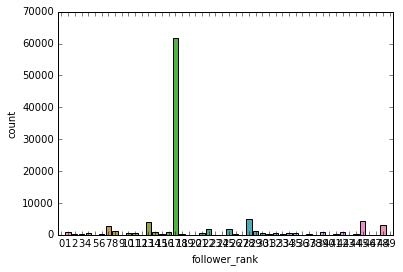

In [159]:
sns.countplot(data['follower_rank'])

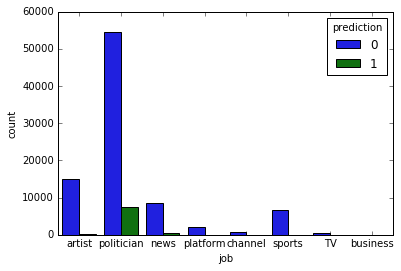

In [154]:
sns.countplot(x="job",hue="prediction", data=data);

In [155]:
data["job"].unique()

array(['artist', 'politician', 'news', nan, 'platform', 'channel',
       'sports', 'TV', 'business'], dtype=object)

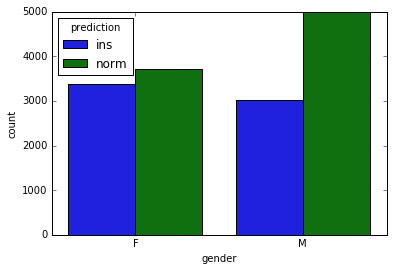

In [156]:
# remove outlier and plot #
sns.countplot(x="gender",hue="prediction", data=lsvmdata.loc[(lsvmdata['user_name']!='realDonaldTrump')&(lsvmdata['job']=='artist')])

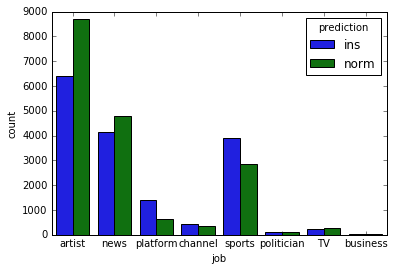

In [160]:
#sns.countplot(x="job",hue="prediction", data=lsvmdata.loc[lsvmdata['user_name']=='CNN'])
sns.countplot(x="job",hue="prediction", data=lsvmdata.loc[lsvmdata['user_name']!='realDonaldTrump'])

/home/ijee/anaconda3/lib/python3.5/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


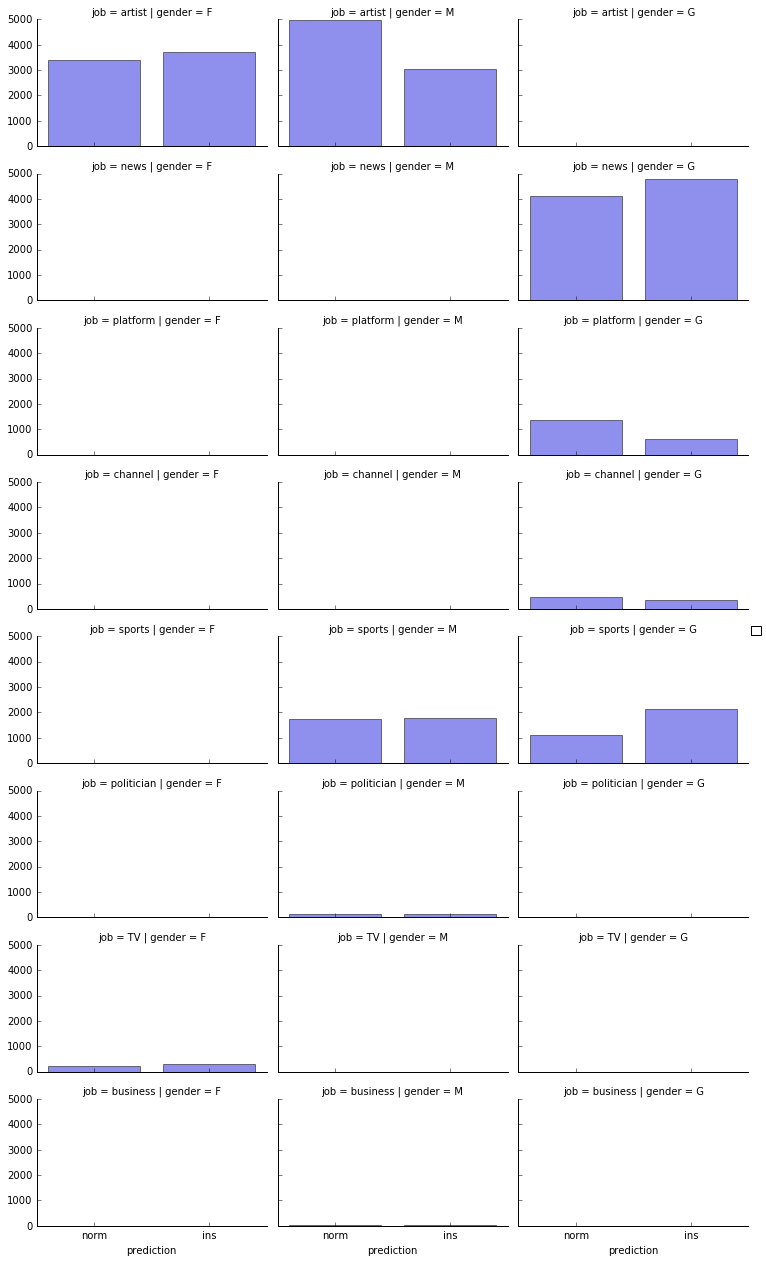

In [158]:
# removing outlier (getting WAY TOO MANY replies than other users)
grid = sns.FacetGrid(lsvmdata.loc[lsvmdata['user_name']!='realDonaldTrump'], col='gender', row='job', size=2.2, aspect=1.6)
grid.map(sns.countplot, 'prediction', alpha=.5)
grid.add_legend();
# among artists, where they have recieved similar amount of replies, the amount of insult female recieve is higher than that toward males

# Conclusions
We have performed sentiment analysis on collected Twitter replies to 50 most followed people, to see if there is a bias in the degree of insult people perceive depending on their background. A few interesting results were found:
## Gender bias in occupation:
Note that all female figures has job that can be categorized either in "artist" or "TV personality", while fields e.g. "business" or "politician", "sports" are all males. 
## Insult bias

##